# Creating a Stress Detection Tool using Data From Subreddits: EDA

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

import pickle

#### Import dataframe from pickle

In [2]:
df = pd.read_pickle('df.pickle')

#### Review dataframe to make sure everything looks right
* .head and .tail
* .shape

In [3]:
df.head(5)

,subreddit,text,text_preproc,label,stress_label
0,happy,Welcome to /r/happy where we support people in...,welcome to rhappy where we support people in t...,0,no stress
1,happy,"You are good people, Mike.",you are good people mike,0,no stress
2,happy,"Wanna come to Knight Lake near Waupaca, Wiscon...",wanna come to knight lake near waupaca wiscons...,0,no stress
3,happy,"“But, I thought the old lady dropped it into t...",“but i thought the old lady dropped it into th...,0,no stress
4,happy,Yay! Thank you for being kind and returning it!,yay thank you for being kind and returning it,0,no stress


In [4]:
df.tail(5)

,subreddit,text,text_preproc,label,stress_label
5136,relationships,"* Her, a week ago: Precious, how are you? (I i...",her a week ago precious how are you i ignored...,0,no stress
5137,ptsd,I don't have the ability to cope with it anymo...,i dont have the ability to cope with it anymor...,1,stress
5138,anxiety,In case this is the first time you're reading ...,in case this is the first time youre reading t...,0,no stress
5139,almosthomeless,Do you find this normal? They have a good rela...,do you find this normal they have a good relat...,0,no stress
5140,ptsd,I was talking to my mom this morning and she s...,i was talking to my mom this morning and she s...,1,stress


In [5]:
df.shape

(5141, 5)

#### Count occurences of each subreddit

In [6]:
df['subreddit'].value_counts()

happy               1217
ptsd                 711
relationships        694
anxiety              650
domesticviolence     388
goodnews             371
assistance           355
survivorsofabuse     315
homeless             220
almosthomeless        99
stress                78
food_pantry           43
Name: subreddit, dtype: int64

#### Subreddits Pie Chart:
* Here we can see the breakdown of which subreddits the comments came from
* Although we called an equal number of 'top posts' from each of these subreddits, each subreddit may have had a different number of top posts and/or number of comments per top post, leading to the discrepencies

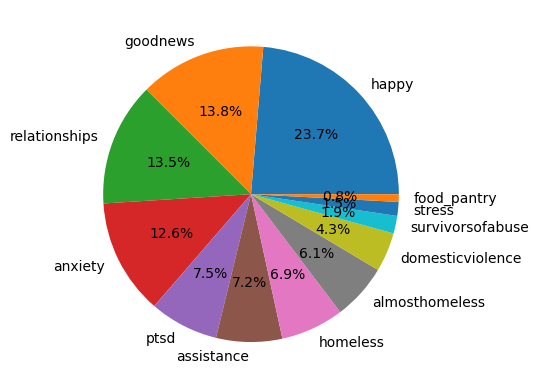

In [7]:
plt.pie(df['subreddit'].value_counts(), labels=df['subreddit'].unique().tolist(), autopct='%1.1f%%')
plt.show()

#### Look at average comment length
* Here we'll look at the min, max, and average length of comments
* Using a histogram we can see that very few comments go above 1000 characters

In [8]:
print('Min length: {}'.format(min(df['text_preproc'].str.len())))
print('Max length: {}'.format(max(df['text_preproc'].str.len())))
print('Average Length :  {}'.format(df['text_preproc'].str.len().mean()))

Min length: 1
Max length: 6262
Average Length :  349.50651624197627


<AxesSubplot: >

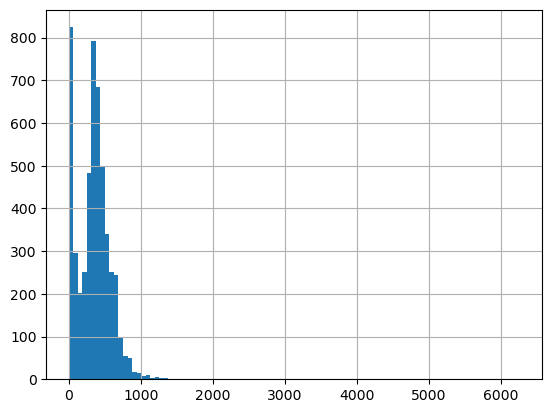

In [9]:
df['text_preproc'].str.len().hist(bins=100)

#### Finding most used words
* First I am splitting the datasets into 'stress' and 'no stress' to find the most common words for each category
* I am then making a corpus by iterating through the preprocessed column of the dataframe
* Then using that I can make a word cloud

#### Split the data

In [10]:
df_stress = df[df["stress_label"] == 'stress']

In [11]:
df_nostress = df[df["stress_label"] == 'no stress']

#### Create the corpus for the stress category

In [12]:
corpus = {}
corpus_string = ''
for t in df_stress:
    corpus[t]= ' '.join(df_stress['text'].tolist())
corpus = list(corpus.values())
for x in corpus:
    corpus_string += x

#### Create the wordcloud

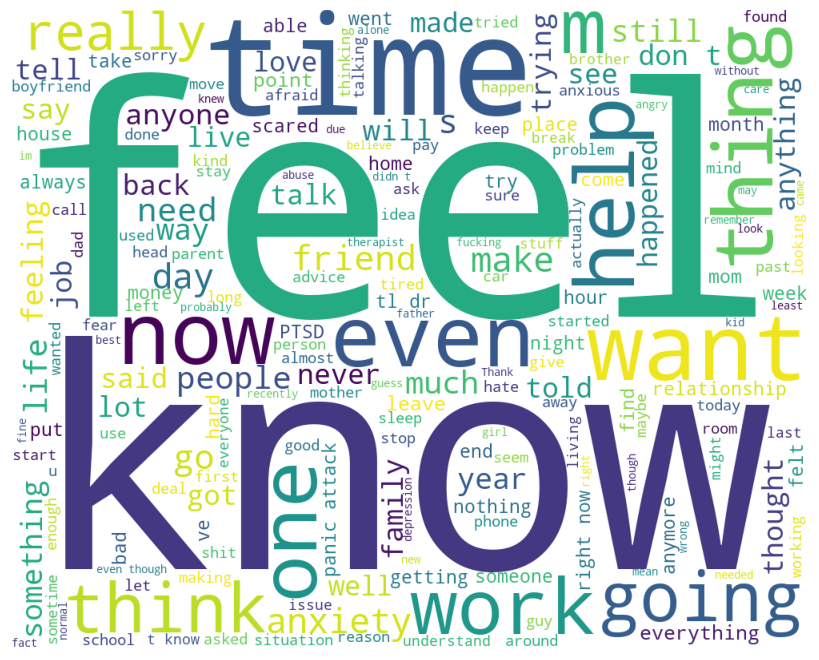

In [13]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white', stopwords = stopwords,
                min_font_size = 10).generate(corpus_string)
plt.figure(figsize = (8, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Some words that stick out here and 'feel,' 'know,' 'time,' 'work,' 'want,' and 'think'

#### Now repeat for the 'no stress' category

In [14]:
corpus_no = {}
corpus_string_no = ''
for t in df_nostress:
    corpus_no[t]= ' '.join(df_nostress['text'].tolist())
corpus_no = list(corpus_no.values())
for x in corpus_no:
    corpus_string_no += x

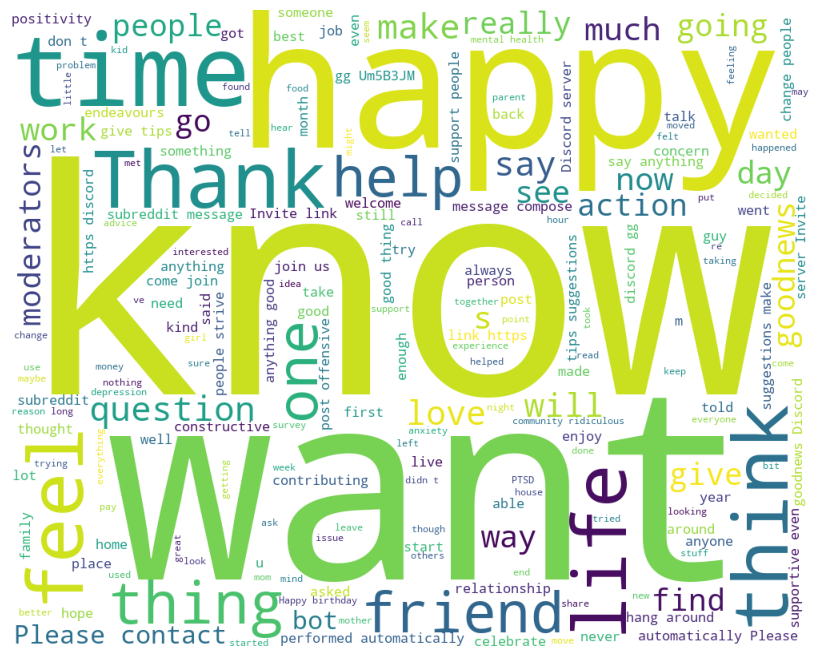

In [15]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white', stopwords = stopwords,
                min_font_size = 10).generate(corpus_string_no)
plt.figure(figsize = (8, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Similarly, 'know,' and 'want,' and pretty prominent but so are 'happy,' 'thank,' 'time,' 'life,' and 'friend'